# 基于PINN 的Lotka-Volterra 方程求解:架构､采样与定义域影响的系统性研究

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.





Compiling model...
'compile' took 0.082200 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.54e+02, 5.02e-01]    [1.54e+02, 5.01e-01]    []  
1000      [3.19e+00, 9.93e-01]    [3.10e+00, 9.90e-01]    []  
2000      [2.42e+00, 8.08e-01]    [2.34e+00, 8.04e-01]    []  
3000      [2.02e+00, 7.14e-01]    [1.95e+00, 7.08e-01]    []  
4000      [1.69e+00, 6.23e-01]    [1.62e+00, 6.15e-01]    []  
5000      [1.38e+00, 5.42e-01]    [1.31e+00, 5.32e-01]    []  
6000      [1.07e+00, 4.72e-01]    [1.01e+00, 4.60e-01]    []  
7000      [7.95e-01, 4.16e-01]    [7.49e-01, 4.04e-01]    []  
8000      [5.72e-01, 3.41e-01]    [5.39e-01, 3.30e-01]    []  
9000      [3.64e-01, 2.73e-01]    [3.43e-01, 2.63e-01]    []  
10000     [2.17e-01, 2.28e-01]    [2.06e-01, 2.20e-01]    []  
11000     [1.72e-01, 1.75e-01]    [1.68e-01, 1.69e-01]    []  
12000     [8.77e-02, 1.27e-01]    [8.65e-02, 1.23e-01]    []  
13000     [5.07e-02, 8.52e-02]    [5.04e-02

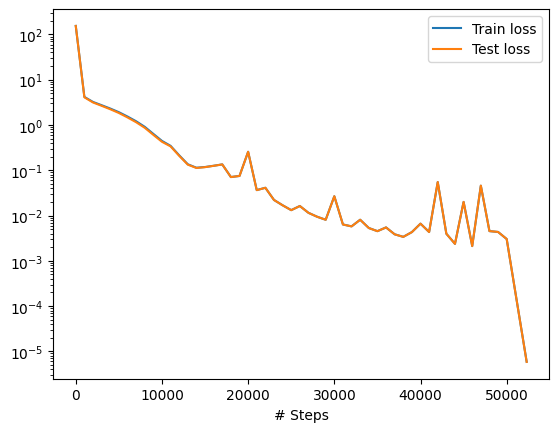

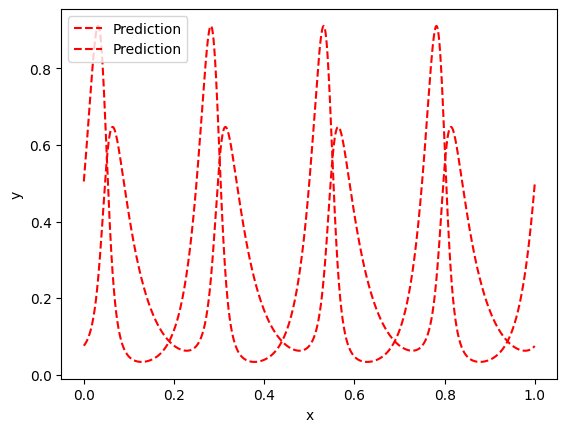

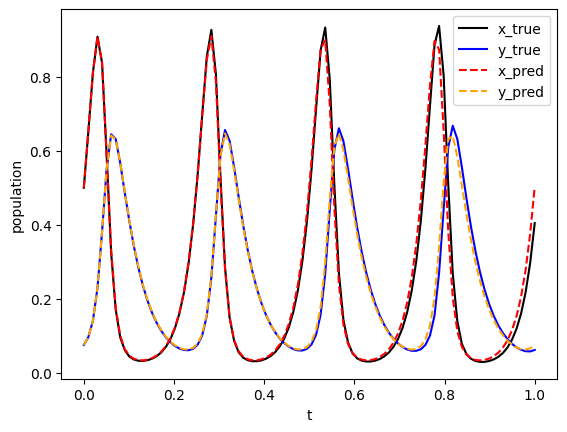

In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle, jax"""

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Import torch if using backend pytorch
# import torch
# Import paddle if using backend paddle
# import paddle
# Import jax.numpy if using backend jax
# import jax.numpy as jnp

ub = 200
rb = 20


def func(t, r):
    x, y = r
    dx_t = 1 / ub * rb * (2.0 * ub * x - 0.04 * ub * x * ub * y)
    dy_t = 1 / ub * rb * (0.02 * ub * x * ub * y - 1.06 * ub * y)
    return dx_t, dy_t


def gen_truedata():
    t = np.linspace(0, 1, 100)

    sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(100, 1)
    y_true = y_true.reshape(100, 1)

    return x_true, y_true


def ode_system(x, y):
    # Most backends
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    # Backend jax
    # y_val, y_fn = y
    # r = y_val[:, 0:1]
    # p = y_val[:, 1:2]
    # dr_t, _ = dde.grad.jacobian(y, x, i=0)
    # dp_t, _ = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - 1 / ub * rb * (2.0 * ub * r - 0.04 * ub * r * ub * p),
        dp_t - 1 / ub * rb * (0.02 * r * ub * p * ub - 1.06 * p * ub),
    ]

geom = dde.geometry.TimeDomain(0, 1.0)
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test=3000)

layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

# Backend tensorflow.compat.v1 or tensorflow
def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )
# Backend pytorch
# def input_transform(t):
#     return torch.cat(
#         [
#             torch.sin(t),
#         ],
#         dim=1,
#     )
# Backend paddle
# def input_transform(t):
#     return paddle.concat(
#         (
#             paddle.sin(t),
#         ),
#         axis=1,
#     )
# Backend jax
# def input_transform(t):
#     if t.ndim == 1:
#         t = t[None]
#
#     return jnp.concatenate(
#         [
#             jnp.sin(t),
#         ],
#         axis=1
#     )

# hard constraints: x(0) = 100, y(0) = 15
# Backend tensorflow.compat.v1 or tensorflow
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    return tf.concat([y1 * tf.tanh(t) + 100 / ub, y2 * tf.tanh(t) + 15 / ub], axis=1)
# Backend pytorch
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return torch.cat([y1 * torch.tanh(t) + 100 / ub, y2 * torch.tanh(t) + 15 / ub], dim=1)
# Backend paddle
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return paddle.concat([y1 * paddle.tanh(t) + 100 / ub, y2 * paddle.tanh(t) + 15 / ub], axis=1)
# Backend jax
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return jnp.concatenate(
#         [y1 * jnp.tanh(t) + 100 / ub, y2 * jnp.tanh(t) + 15 / ub],
#         axis=1
#     ).squeeze()

net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)
model = dde.Model(data, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=50000)
# Most backends except jax can have a second fine tuning of the solution
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

plt.xlabel("t")
plt.ylabel("population")

t = np.linspace(0, 1, 100)
x_true, y_true = gen_truedata()
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()

## 1. 简单对比不同网络架构

In [4]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

ub = 200
rb = 20

def ode_system(x, y):
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - 1/ub * rb * (2.0*ub*r - 0.04*ub*r*ub*p),
        dp_t - 1/ub * rb * (0.02*r*ub*p*ub - 1.06*p*ub),
    ]

def test_different_architectures():
    """测试不同的网络架构"""
    
    # 定义几种网络架构
    architectures = {
        "Shallow(32-32)": [1, 32, 32, 2],
        "Standard(64-64-64)": [1, 64, 64, 64, 2],
        "Deep(8 layers)": [1, 64, 64, 64, 64, 64, 64, 64, 2],
        "Wide(128-128)": [1, 128, 128, 2],
        "Narrow(16-16-16)": [1, 16, 16, 16, 2],
    }
    
    results = {}
    
    for name, layers in architectures.items():
        print(f"\nTraining {name} ...")
        
        # 创建几何域和数据
        geom = dde.geometry.TimeDomain(0, 1.0)
        data = dde.data.PDE(geom, ode_system, [], 2000, 2, num_test=1000)
        
        # 创建网络
        net = dde.nn.FNN(layers, "tanh", "Glorot normal")
        
        # 输入输出变换
        import deepxde.backend as bkd
        
        def output_transform(t, y):
            return bkd.concat([y[:, 0:1]*bkd.tanh(t) + 100/ub, 
                              y[:, 1:2]*bkd.tanh(t) + 15/ub], axis=1)
        
        net.apply_output_transform(output_transform)
        
        # 训练
        model = dde.Model(data, net)
        model.compile("adam", lr=0.001)
        model.train(iterations=10000, display_every=2000)
        
        # 测试
        t = np.linspace(0, 1, 100).reshape(-1, 1)
        pred = model.predict(t)
        
        # 计算真实值
        def func(t, r):
            x, y = r
            return [1/ub*rb*(2.0*ub*x - 0.04*ub*x*ub*y),
                   1/ub*rb*(0.02*ub*x*ub*y - 1.06*ub*y)]
        
        sol = integrate.solve_ivp(func, (0, 10), (100/ub, 15/ub), t_eval=t.flatten())
        x_true = sol.y[0].reshape(-1, 1)
        y_true = sol.y[1].reshape(-1, 1)
        
        # 计算误差
        error = np.mean(np.abs(pred[:, 0:1] - x_true) + np.abs(pred[:, 1:2] - y_true))
        results[name] = {
            'error': error,
            'pred': pred,
            'true': (x_true, y_true)
        }
        
        print(f"Error: {error:.6f}")
    
    # 绘制结果
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, (name, result) in enumerate(results.items()):
        ax = axes[idx]
        t = np.linspace(0, 1, 100)
        x_true, y_true = result['true']
        pred = result['pred']
        
        ax.plot(t, x_true, 'k-', label='x_true', linewidth=2)
        ax.plot(t, y_true, 'b-', label='y_true', linewidth=2)
        ax.plot(t, pred[:, 0], 'r--', label='x_pred', alpha=0.8)
        ax.plot(t, pred[:, 1], 'g--', label='y_pred', alpha=0.8)
        
        ax.set_title(f"{name}\nError: {result['error']:.4f}")
        ax.set_xlabel('t')
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.legend()
    
    # 隐藏多余的子图
    for idx in range(len(results), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 绘制误差比较图
    plt.figure(figsize=(10, 6))
    names = list(results.keys())
    errors = [results[n]['error'] for n in names]
    
    bars = plt.bar(names, errors, alpha=0.7)
    plt.ylabel('Total Error')
    plt.title('Prediction Error Comparison of Different Network Architectures')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # 在柱子上添加误差值
    for bar, error in zip(bars, errors):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{error:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 打印详细结果
    print("\n" + "="*60)
    print("RESULTS SUMMARY:")
    print("="*60)
    for name in results:
        print(f"{name:<20} Error: {results[name]['error']:.6f}")



Training Shallow(32-32) ...
Compiling model...
'compile' took 0.009008 s

Training model...

Step      Train loss              Test loss               Test metric
0         [3.77e+02, 1.03e+00]    [3.77e+02, 1.03e+00]    []  
2000      [8.29e+00, 1.33e+00]    [8.03e+00, 1.33e+00]    []  
4000      [3.02e+00, 6.23e-01]    [2.81e+00, 6.04e-01]    []  
6000      [1.28e+00, 7.15e-01]    [1.16e+00, 6.72e-01]    []  
8000      [7.69e-01, 5.59e-01]    [6.95e-01, 5.21e-01]    []  
10000     [5.12e-01, 3.27e-01]    [4.64e-01, 3.00e-01]    []  

Best model at step 10000:
  train loss: 8.39e-01
  test loss: 7.64e-01
  test metric: []

'train' took 26.080151 s

Error: 0.423150

Training Standard(64-64-64) ...
Compiling model...
'compile' took 0.002514 s

Training model...

Step      Train loss              Test loss               Test metric
0         [7.49e+01, 1.67e+00]    [7.47e+01, 1.67e+00]    []  
2000      [2.05e+00, 6.33e-01]    [1.86e+00, 5.93e-01]    []  
4000      [8.49e-01, 4.45e-01] 

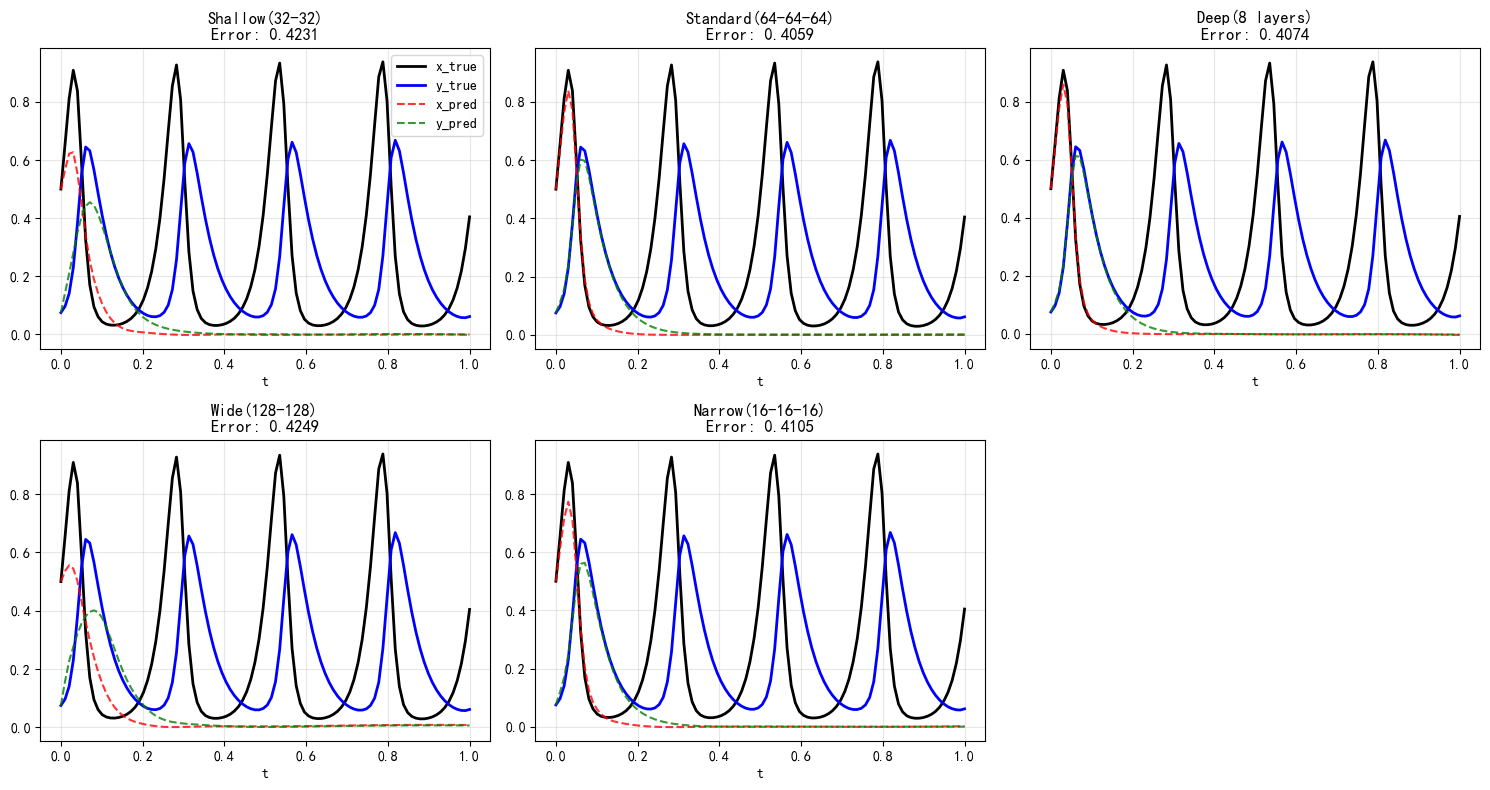

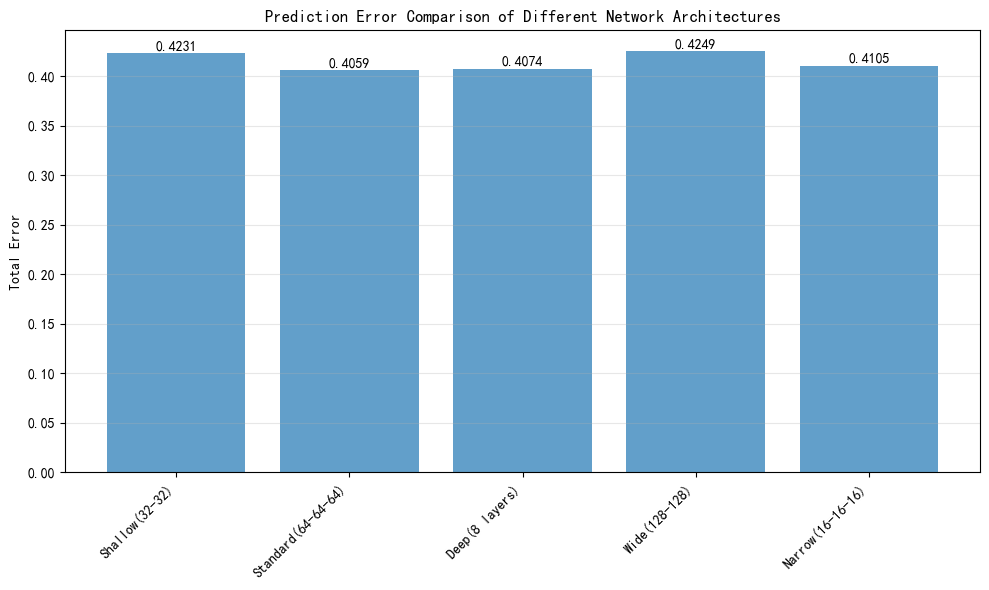


RESULTS SUMMARY:
Shallow(32-32)       Error: 0.423150
Standard(64-64-64)   Error: 0.405866
Deep(8 layers)       Error: 0.407446
Wide(128-128)        Error: 0.424918
Narrow(16-16-16)     Error: 0.410507


In [5]:

# ==================== 运行实验 ====================

test_different_architectures()

## 2. 测试不同采样点数

In [6]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Try to set Chinese font, fall back to English if not available
try:
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    use_chinese = True
except:
    use_chinese = False
    print("Chinese fonts not available, using English labels")

ub = 200
rb = 20

def ode_system(x, y):
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - 1/ub * rb * (2.0*ub*r - 0.04*ub*r*ub*p),
        dp_t - 1/ub * rb * (0.02*r*ub*p*ub - 1.06*p*ub),
    ]

def test_different_sample_points():
    """Test different numbers of sample points"""
    
    sample_points = [500, 1000, 2000, 3000, 5000]
    results = {}
    
    for num_points in sample_points:
        print(f"\nTraining with {num_points} sample points ...")
        
        # Create geometry and data
        geom = dde.geometry.TimeDomain(0, 1.0)
        data = dde.data.PDE(geom, ode_system, [], num_points, 2, num_test=1000)
        
        # Fixed network architecture
        net = dde.nn.FNN([1, 64, 64, 64, 2], "tanh", "Glorot normal")
        
        # Output transform
        import deepxde.backend as bkd
        
        def output_transform(t, y):
            return bkd.concat([y[:, 0:1]*bkd.tanh(t) + 100/ub, 
                              y[:, 1:2]*bkd.tanh(t) + 15/ub], axis=1)
        
        net.apply_output_transform(output_transform)
        
        # Train
        model = dde.Model(data, net)
        model.compile("adam", lr=0.001)
        model.train(iterations=10000, display_every=2000)
        
        # Test
        t = np.linspace(0, 1, 100).reshape(-1, 1)
        pred = model.predict(t)
        
        # Compute true values
        def func(t, r):
            x, y = r
            return [1/ub*rb*(2.0*ub*x - 0.04*ub*x*ub*y),
                   1/ub*rb*(0.02*ub*x*ub*y - 1.06*ub*y)]
        
        sol = integrate.solve_ivp(func, (0, 10), (100/ub, 15/ub), t_eval=t.flatten())
        x_true = sol.y[0].reshape(-1, 1)
        y_true = sol.y[1].reshape(-1, 1)
        
        # Compute error
        error = np.mean(np.abs(pred[:, 0:1] - x_true) + np.abs(pred[:, 1:2] - y_true))
        results[num_points] = {
            'error': error,
            'pred': pred,
            'true': (x_true, y_true)
        }
        
        print(f"Sample points: {num_points}, Error: {error:.6f}")
    
    # Plot results
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, (num_points, result) in enumerate(results.items()):
        ax = axes[idx]
        t = np.linspace(0, 1, 100)
        x_true, y_true = result['true']
        pred = result['pred']
        
        ax.plot(t, x_true, 'k-', label='x_true', linewidth=2)
        ax.plot(t, y_true, 'b-', label='y_true', linewidth=2)
        ax.plot(t, pred[:, 0], 'r--', label='x_pred', alpha=0.8)
        ax.plot(t, pred[:, 1], 'g--', label='y_pred', alpha=0.8)
        
        # Use appropriate labels based on font availability
        if use_chinese:
            ax.set_title(f"{num_points} 个采样点\n误差: {result['error']:.4f}")
            ax.set_xlabel('时间 t')
            ax.set_ylabel('种群数量')
        else:
            ax.set_title(f"{num_points} Sample Points\nError: {result['error']:.4f}")
            ax.set_xlabel('t')
            ax.set_ylabel('Population')
            
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.legend()
    
    # Last subplot shows error trend
    ax = axes[-1]
    points = list(results.keys())
    errors = [results[p]['error'] for p in points]
    
    ax.plot(points, errors, 'bo-', linewidth=2, markersize=8)
    
    # Set labels based on language
    if use_chinese:
        ax.set_xlabel('采样点数')
        ax.set_ylabel('误差')
        ax.set_title('采样点数与误差关系')
    else:
        ax.set_xlabel('Number of Sample Points')
        ax.set_ylabel('Error')
        ax.set_title('Error vs Number of Sample Points')
        
    ax.grid(True, alpha=0.3)
    
    # Add error labels
    for x, y in zip(points, errors):
        ax.text(x, y + 0.001, f'{y:.4f}', ha='center')
    
    # Set main title
    if use_chinese:
        plt.suptitle('不同采样点数对预测效果的影响', fontsize=14)
    else:
        plt.suptitle('Effect of Different Numbers of Sample Points', fontsize=14)
        
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: Error reduction rate
    print("\n" + "="*60)
    if use_chinese:
        print("误差分析:")
    else:
        print("ERROR ANALYSIS:")
    print("="*60)
    
    sorted_points = sorted(results.keys())
    for i in range(1, len(sorted_points)):
        prev_error = results[sorted_points[i-1]]['error']
        curr_error = results[sorted_points[i]]['error']
        reduction = (prev_error - curr_error) / prev_error * 100
        
        if use_chinese:
            print(f"从 {sorted_points[i-1]} 到 {sorted_points[i]} 点: "
                  f"误差减少 {reduction:+.1f}%")
        else:
            print(f"From {sorted_points[i-1]} to {sorted_points[i]} points: "
                  f"Error reduction {reduction:+.1f}%")


Training with 500 sample points ...
Compiling model...
'compile' took 0.002194 s

Training model...

Step      Train loss              Test loss               Test metric
0         [7.53e+01, 1.67e+00]    [7.47e+01, 1.67e+00]    []  
2000      [2.12e+00, 6.60e-01]    [1.80e+00, 5.94e-01]    []  
4000      [8.10e-01, 3.77e-01]    [6.88e-01, 3.31e-01]    []  
6000      [2.02e-01, 8.51e-02]    [1.79e-01, 6.95e-02]    []  
8000      [6.17e-02, 3.73e-02]    [5.95e-02, 2.87e-02]    []  
10000     [3.44e-02, 2.32e-02]    [3.47e-02, 1.74e-02]    []  

Best model at step 10000:
  train loss: 5.76e-02
  test loss: 5.21e-02
  test metric: []

'train' took 23.932960 s

Sample points: 500, Error: 0.406183

Training with 1000 sample points ...
Compiling model...
'compile' took 0.001938 s

Training model...

Step      Train loss              Test loss               Test metric
0         [7.50e+01, 1.67e+00]    [7.47e+01, 1.67e+00]    []  
2000      [2.05e+00, 6.41e-01]    [1.83e+00, 5.92e-01]    [] 

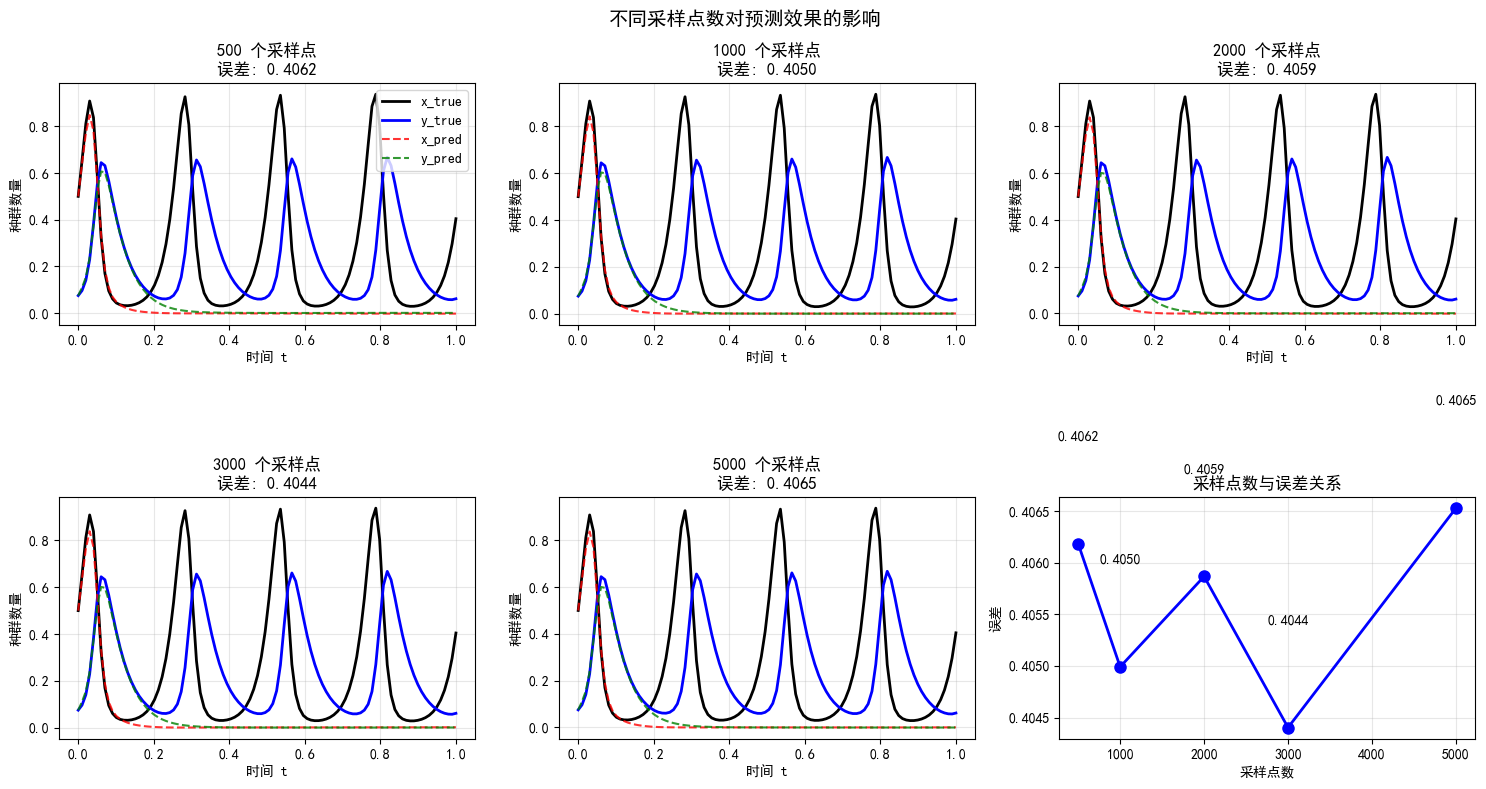


误差分析:
从 500 到 1000 点: 误差减少 +0.3%
从 1000 到 2000 点: 误差减少 -0.2%
从 2000 到 3000 点: 误差减少 +0.4%
从 3000 到 5000 点: 误差减少 -0.5%


In [ ]:
test_different_sample_points()

## 3. 不同采样策略

In [27]:
def visualize_experiment_results(results):
    """可视化实验结果（只保留6个子图）"""
    strategies = list(results.keys())
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 子图1: 第一种策略的预测结果
    ax = axes[0, 0]
    strategy = strategies[0]
    result = results[strategy]
    t = np.linspace(0, 1, 100)
    x_true, y_true = result['true']
    pred = result['pred']
    
    ax.plot(t, x_true, 'k-', label='x_true', linewidth=2)
    ax.plot(t, y_true, 'b-', label='y_true', linewidth=2)
    ax.plot(t, pred[:, 0], 'r--', label='x_pred', alpha=0.8)
    ax.plot(t, pred[:, 1], 'g--', label='y_pred', alpha=0.8)
    
    ax.set_title(f'{strategy} 预测结果\n误差: {result["total_error"]:.4f}')
    ax.set_xlabel('时间 t')
    ax.set_ylabel('种群数量')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # 子图2: 第二种策略的预测结果
    ax = axes[0, 1]
    strategy = strategies[1]
    result = results[strategy]
    pred = result['pred']
    
    ax.plot(t, x_true, 'k-', label='x_true', linewidth=2)
    ax.plot(t, y_true, 'b-', label='y_true', linewidth=2)
    ax.plot(t, pred[:, 0], 'r--', label='x_pred', alpha=0.8)
    ax.plot(t, pred[:, 1], 'g--', label='y_pred', alpha=0.8)
    
    ax.set_title(f'{strategy} 预测结果\n误差: {result["total_error"]:.4f}')
    ax.set_xlabel('时间 t')
    ax.set_ylabel('种群数量')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # 子图3: 第三种策略的预测结果
    ax = axes[0, 2]
    strategy = strategies[2]
    result = results[strategy]
    pred = result['pred']
    
    ax.plot(t, x_true, 'k-', label='x_true', linewidth=2)
    ax.plot(t, y_true, 'b-', label='y_true', linewidth=2)
    ax.plot(t, pred[:, 0], 'r--', label='x_pred', alpha=0.8)
    ax.plot(t, pred[:, 1], 'g--', label='y_pred', alpha=0.8)
    
    ax.set_title(f'{strategy} 预测结果\n误差: {result["total_error"]:.4f}')
    ax.set_xlabel('时间 t')
    ax.set_ylabel('种群数量')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # 子图4: 整体误差对比
    ax = axes[1, 0]
    total_errors = [results[s]['total_error'] for s in strategies]
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    bars = ax.bar(strategies, total_errors, color=colors, alpha=0.7)
    ax.set_xlabel('采样策略')
    ax.set_ylabel('整体误差')
    ax.set_title('整体误差对比')
    ax.tick_params(axis='x', rotation=30)
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, error in zip(bars, total_errors):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{error:.4f}', ha='center', va='bottom')
    
    # 子图5: 边界误差 vs 内部误差
    ax = axes[1, 1]
    x = np.arange(len(strategies))
    width = 0.35
    
    boundary_errors = [results[s]['boundary_error'] for s in strategies]
    interior_errors = [results[s]['interior_error'] for s in strategies]
    
    ax.bar(x - width/2, boundary_errors, width, label='边界误差', alpha=0.7, color='red')
    ax.bar(x + width/2, interior_errors, width, label='内部误差', alpha=0.7, color='blue')
    
    ax.set_xlabel('采样策略')
    ax.set_ylabel('预测误差')
    ax.set_title('边界与内部误差对比')
    ax.set_xticks(x)
    ax.set_xticklabels(strategies, rotation=30)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    # 子图6: 误差分布均匀性
    ax = axes[1, 2]
    error_ratios = []
    for strategy in strategies:
        if results[strategy]['interior_error'] > 0:
            ratio = results[strategy]['boundary_error'] / results[strategy]['interior_error']
            error_ratios.append(ratio)
        else:
            error_ratios.append(0)
    
    bars = ax.bar(strategies, error_ratios, alpha=0.7, color='purple')
    ax.set_xlabel('采样策略')
    ax.set_ylabel('边界误差/内部误差')
    ax.set_title('误差分布均匀性')
    ax.tick_params(axis='x', rotation=30)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    
    for bar, ratio in zip(bars, error_ratios):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{ratio:.2f}', ha='center', va='bottom')
    
    plt.suptitle('PINN不同采样策略对比实验结果', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

PINN不同采样策略对比实验

可视化不同采样策略的点分布...


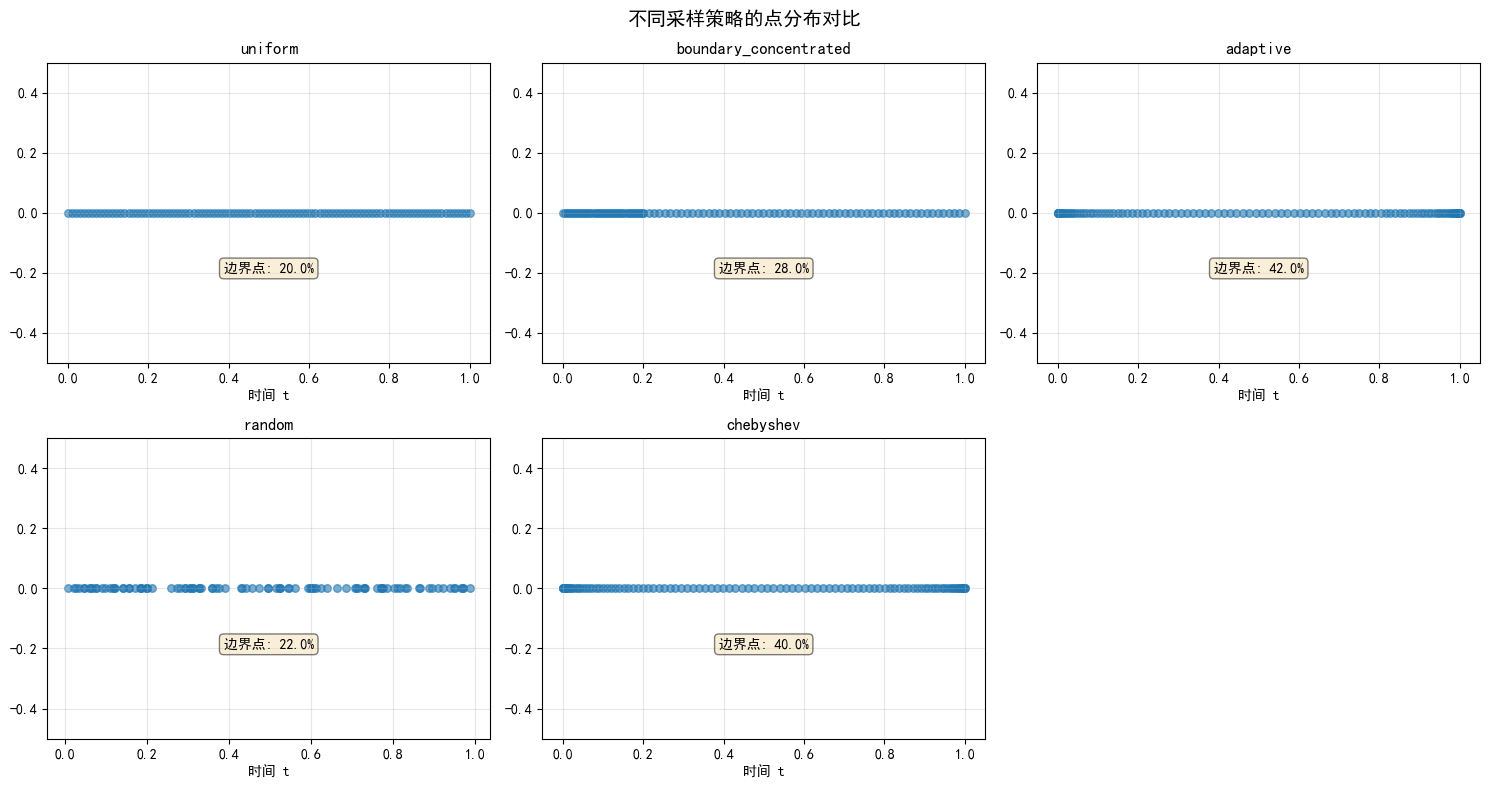


使用 uniform 采样策略
Compiling model...
'compile' took 0.002399 s

开始训练...
Training model...

Cause: could not parse the source code of <function create_pde_data_with_sampling_strategy.<locals>.<lambda> at 0x0000020A6D823600>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function create_pde_data_with_sampling_strategy.<locals>.<lambda> at 0x0000020A6D823600>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda 

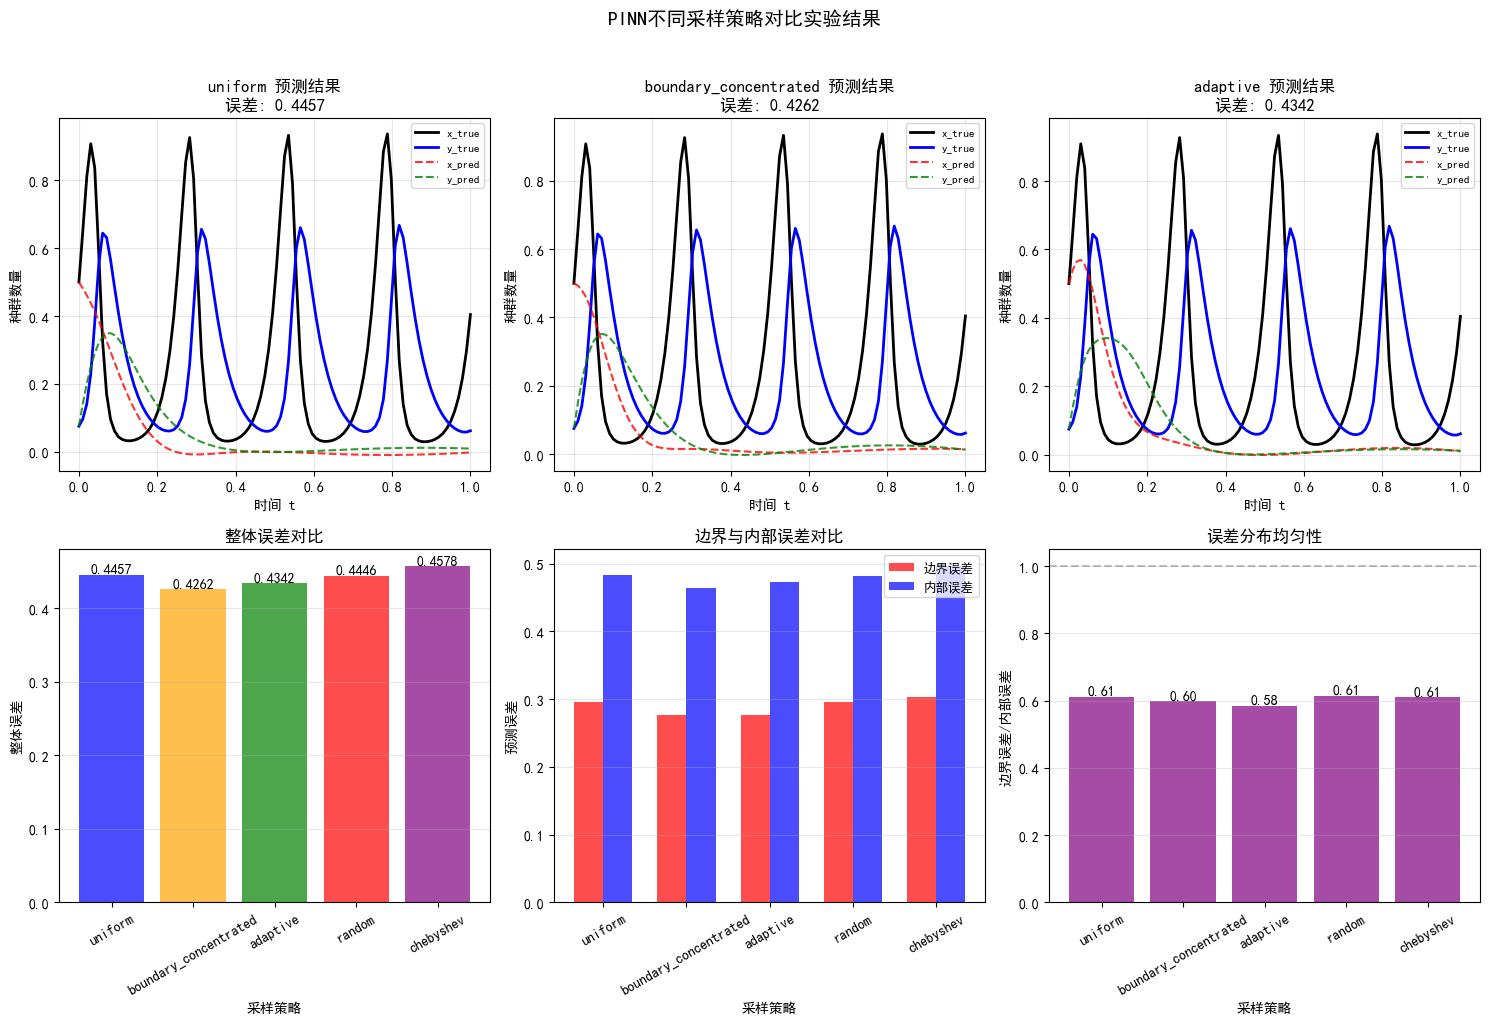

{'uniform': {'total_error': np.float64(0.4457428749628094),
  'boundary_error': np.float64(0.2954962873372102),
  'interior_error': np.float64(0.48330452186920925),
  'pred': array([[ 5.00000000e-01,  7.50000030e-02],
         [ 4.81654644e-01,  1.42156169e-01],
         [ 4.61167455e-01,  2.01072380e-01],
         [ 4.38362658e-01,  2.50719428e-01],
         [ 4.13215786e-01,  2.90365189e-01],
         [ 3.85887384e-01,  3.19689155e-01],
         [ 3.56727868e-01,  3.38846982e-01],
         [ 3.26248735e-01,  3.48466516e-01],
         [ 2.95065880e-01,  3.49573553e-01],
         [ 2.63830870e-01,  3.43468189e-01],
         [ 2.33166635e-01,  3.31582785e-01],
         [ 2.03619301e-01,  3.15351546e-01],
         [ 1.75631315e-01,  2.96107352e-01],
         [ 1.49533093e-01,  2.75017738e-01],
         [ 1.25547558e-01,  2.53052533e-01],
         [ 1.03802562e-01,  2.30979100e-01],
         [ 8.43460858e-02,  2.09376603e-01],
         [ 6.71615005e-02,  1.88658118e-01],
         [ 5.2181

In [28]:
np.random.seed(42)
test_different_sampling_strategies()

# DeepONet 反导数求解的性能优化:架构､采样与点数影响分析

Compiling model...
'compile' took 0.043098 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.19e-01]    [9.32e-01]    [2.07e+00]    
1000      [1.62e-04]    [2.08e-04]    [5.22e-02]    
2000      [4.10e-05]    [7.89e-05]    [3.29e-02]    
3000      [1.88e-05]    [4.54e-05]    [2.47e-02]    
4000      [5.00e-05]    [5.91e-05]    [2.38e-02]    
5000      [8.17e-06]    [2.57e-05]    [1.87e-02]    
6000      [6.52e-06]    [2.24e-05]    [1.75e-02]    
7000      [6.48e-06]    [1.93e-05]    [1.66e-02]    
8000      [4.72e-06]    [1.67e-05]    [1.56e-02]    
9000      [4.32e-06]    [1.44e-05]    [1.47e-02]    
10000     [3.59e-06]    [1.23e-05]    [1.38e-02]    

Best model at step 10000:
  train loss: 3.59e-06
  test loss: 1.23e-05
  test metric: [1.38e-02]

'train' took 12.833608 s



Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

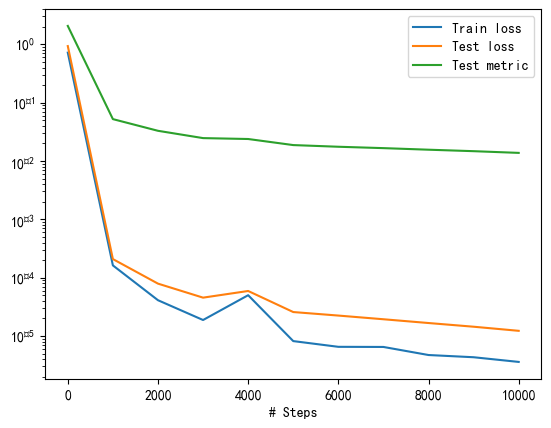

In [13]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
d = np.load("deeponet_antiderivative_aligned/antiderivative_aligned_train.npz", allow_pickle=True)
X_train = (d["X"][0].astype(np.float32), d["X"][1].astype(np.float32))
y_train = d["y"].astype(np.float32)
d = np.load("deeponet_antiderivative_aligned/antiderivative_aligned_test.npz", allow_pickle=True)
X_test = (d["X"][0].astype(np.float32), d["X"][1].astype(np.float32))
y_test = d["y"].astype(np.float32)

data = dde.data.TripleCartesianProd(
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)

# Choose a network
m = 100
dim_x = 1
net = dde.nn.DeepONetCartesianProd(
    [m, 40, 40],
    [dim_x, 40, 40],
    "relu",
    "Glorot normal",
)

# Define a Model
model = dde.Model(data, net)

# Compile and Train
model.compile("adam", lr=0.001, metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

# Plot the loss trajectory
dde.utils.plot_loss_history(losshistory)
plt.show()

## 网络架构对比实验

In [1]:
"""DeepONet网络架构对比实验"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from matplotlib import rcParams

# 设置中文字体（如果系统支持）
def setup_chinese_font():
    """设置中文字体，支持多平台"""
    if os.name == 'nt':  # Windows
        font_candidates = ['SimHei', 'Microsoft YaHei', 'KaiTi']
    else:  # Linux/Mac
        font_candidates = ['WenQuanYi Zen Hei', 'Noto Sans CJK SC', 'DejaVu Sans']
    
    for font_name in font_candidates:
        try:
            rcParams['font.sans-serif'] = [font_name]
            rcParams['axes.unicode_minus'] = False
            # 测试字体
            test_fig, test_ax = plt.subplots(figsize=(1, 1))
            test_ax.set_title('测试', fontsize=12)
            plt.close(test_fig)
            print(f"✓ 成功设置字体: {font_name}")
            return True
        except:
            continue
    print("⚠ 警告: 使用默认字体")
    return False

setup_chinese_font()

def load_antiderivative_data(train_path="deeponet_antiderivative_aligned/antiderivative_aligned_train.npz",
                            test_path="deeponet_antiderivative_aligned/antiderivative_aligned_test.npz"):
    """加载反导数对齐数据集"""
    d_train = np.load(train_path, allow_pickle=True)
    d_test = np.load(test_path, allow_pickle=True)
    
    X_train = (d_train["X"][0].astype(np.float32), d_train["X"][1].astype(np.float32))
    y_train = d_train["y"].astype(np.float32)
    X_test = (d_test["X"][0].astype(np.float32), d_test["X"][1].astype(np.float32))
    y_test = d_test["y"].astype(np.float32)
    
    print(f"训练数据形状: X[0]={X_train[0].shape}, X[1]={X_train[1].shape}, y={y_train.shape}")
    print(f"测试数据形状: X[0]={X_test[0].shape}, X[1]={X_test[1].shape}, y={y_test.shape}")
    
    data = dde.data.TripleCartesianProd(
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
    )
    return data, X_train, y_train, X_test, y_test

def experiment_network_architectures():
    """实验1: 测试不同网络架构对DeepONet性能的影响"""
    print("\n" + "="*60)
    print("DeepONet网络架构对比实验")
    print("="*60)
    
    # 检查数据文件
    data_files = [
        "deeponet_antiderivative_aligned/antiderivative_aligned_train.npz",
        "deeponet_antiderivative_aligned/antiderivative_aligned_test.npz"
    ]
    
    missing_files = []
    for file in data_files:
        if not os.path.exists(file):
            missing_files.append(file)
    
    if missing_files:
        print("错误: 缺少数据文件:")
        for file in missing_files:
            print(f"  - {file}")
        print("\n请确保数据文件在正确的路径下。")
        return
    
    # 加载数据
    data, X_train, y_train, X_test, y_test = load_antiderivative_data()
    
    # 定义不同的网络架构配置
    architectures = {
        "浅层网络(40-40)": {
            "branch": [100, 40, 40],
            "trunk": [1, 40, 40],
            "description": "浅层网络，分支和主干各2个隐藏层"
        },
        "标准网络(40-40-40)": {
            "branch": [100, 40, 40, 40],
            "trunk": [1, 40, 40, 40],
            "description": "标准网络，分支和主干各3个隐藏层"
        },
        "深层网络(6层)": {
            "branch": [100, 64, 64, 64, 64, 64, 64],
            "trunk": [1, 64, 64, 64, 64, 64, 64],
            "description": "深层网络，分支和主干各6个隐藏层"
        },
        "宽网络(128-128)": {
            "branch": [100, 128, 128],
            "trunk": [1, 128, 128],
            "description": "宽网络，分支和主干各2个宽层"
        },
        "不对称网络(分支深)": {
            "branch": [100, 64, 64, 64, 40],
            "trunk": [1, 40, 40],
            "description": "分支网络更深，主干较浅"
        }
    }
    
    results = {}
    
    for name, config in architectures.items():
        print(f"\n训练 {name} ...")
        print(f"配置: {config['description']}")
        print(f"分支网络: {config['branch']}")
        print(f"主干网络: {config['trunk']}")
        
        # 创建网络
        net = dde.nn.DeepONetCartesianProd(
            config["branch"],
            config["trunk"],
            "relu",
            "Glorot normal",
        )
        
        # 创建模型
        model = dde.Model(data, net)
        
        # 编译和训练
        start_time = time.time()
        model.compile("adam", lr=0.001, metrics=["mean l2 relative error"])
        losshistory, train_state = model.train(
            iterations=5000, 
            display_every=1000,
            batch_size=None
        )
        training_time = time.time() - start_time
        
        # 记录结果
        final_train_loss = losshistory.loss_train[-1][0]
        final_test_loss = losshistory.loss_test[-1][0] if losshistory.loss_test else None
        final_metric = losshistory.metrics_test[-1][0] if losshistory.metrics_test else None
        
        results[name] = {
            'config': config,
            'train_loss': final_train_loss,
            'test_loss': final_test_loss,
            'metric': final_metric,
            'training_time': training_time,
            'losshistory': losshistory,
            'train_state': train_state
        }
        
        print(f"训练时间: {training_time:.1f}秒")
        print(f"最终训练损失: {final_train_loss:.6f}")
        if final_metric:
            print(f"最终L2相对误差: {final_metric:.6f}")
    
    # 可视化结果
    visualize_architecture_results(results)
    
    return results

def visualize_architecture_results(results):
    """可视化网络架构实验结果"""
    plt.figure(figsize=(14, 10))
    
    # 子图1: 训练损失曲线
    plt.subplot(2, 2, 1)
    for name, result in results.items():
        if result['losshistory'].loss_train:
            losses = [loss[0] for loss in result['losshistory'].loss_train]
            plt.plot(losses, label=name, linewidth=2, alpha=0.8)
    plt.xlabel('迭代次数', fontsize=12)
    plt.ylabel('训练损失', fontsize=12)
    plt.title('不同网络架构的训练损失曲线', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # 子图2: 最终性能对比
    plt.subplot(2, 2, 2)
    names = list(results.keys())
    train_losses = [results[n]['train_loss'] for n in names]
    
    # 创建柱状图
    x = np.arange(len(names))
    width = 0.35
    
    bars1 = plt.bar(x, train_losses, width, label='训练损失', alpha=0.7)
    
    plt.xlabel('网络架构', fontsize=12)
    plt.ylabel('损失值', fontsize=12)
    plt.title('最终训练损失对比', fontsize=14)
    plt.xticks(x, names, rotation=30, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # 在柱子上添加数值
    for bar, loss in zip(bars1, train_losses):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{loss:.2e}', ha='center', va='bottom', fontsize=9)
    
    # 子图3: 训练时间对比
    plt.subplot(2, 2, 3)
    training_times = [results[n]['training_time'] for n in names]
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(names)))
    
    bars2 = plt.bar(names, training_times, color=colors, alpha=0.7)
    plt.xlabel('网络架构', fontsize=12)
    plt.ylabel('训练时间 (秒)', fontsize=12)
    plt.title('训练时间对比', fontsize=14)
    plt.xticks(rotation=30, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    for bar, time_val in zip(bars2, training_times):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{time_val:.1f}', ha='center', va='bottom', fontsize=9)
    
    # 子图4: 参数数量估计
    plt.subplot(2, 2, 4)
    param_estimates = []
    for name, result in results.items():
        branch = result['config']['branch']
        trunk = result['config']['trunk']
        # 简单估计参数数量
        branch_params = sum(branch[i] * branch[i+1] for i in range(len(branch)-1))
        trunk_params = sum(trunk[i] * trunk[i+1] for i in range(len(trunk)-1))
        # 加上偏置项
        branch_params += sum(branch[1:])
        trunk_params += sum(trunk[1:])
        total_params = branch_params + trunk_params
        param_estimates.append(total_params)
    
    plt.bar(names, param_estimates, color='skyblue', alpha=0.7)
    plt.xlabel('网络架构', fontsize=12)
    plt.ylabel('参数数量估计', fontsize=12)
    plt.title('网络复杂度对比', fontsize=14)
    plt.xticks(rotation=30, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.yscale('log')
    
    plt.suptitle('DeepONet网络架构对比实验', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('deeponet_network_architectures_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印详细结果
    print("\n" + "="*70)
    print("网络架构实验结果汇总")
    print("="*70)
    print(f"{'网络架构':<20} {'训练损失':<12} {'训练时间(秒)':<15} {'参数估计':<12} {'排名'}")
    print("-"*70)
    
    # 按训练损失排序
    sorted_names = sorted(results.keys(), key=lambda x: results[x]['train_loss'])
    for rank, name in enumerate(sorted_names, 1):
        print(f"{name:<20} {results[name]['train_loss']:<12.2e} "
              f"{results[name]['training_time']:<15.1f} "
              f"{param_estimates[names.index(name)]:<12,} {rank}")
    
    # 分析最佳配置
    best_arch = min(results.keys(), key=lambda x: results[x]['train_loss'])
    worst_arch = max(results.keys(), key=lambda x: results[x]['train_loss'])
    performance_improvement = (
        (results[worst_arch]['train_loss'] - results[best_arch]['train_loss']) / 
        results[worst_arch]['train_loss'] * 100
    )
    
    print("\n" + "-"*70)
    print("关键发现:")
    print(f"1. 最佳架构: {best_arch} (损失: {results[best_arch]['train_loss']:.2e})")
    print(f"2. 最差架构: {worst_arch} (损失: {results[worst_arch]['train_loss']:.2e})")
    print(f"3. 性能提升: {performance_improvement:.1f}%")
    
    # 分析时间效率
    fastest_arch = min(results.keys(), key=lambda x: results[x]['training_time'])
    print(f"4. 最快训练: {fastest_arch} ({results[fastest_arch]['training_time']:.1f}秒)")
    
    # 计算效率评分
    print("\n综合效率评分（综合考虑损失和时间）:")
    efficiency_scores = []
    for name in names:
        # 归一化损失和时间
        losses = [results[n]['train_loss'] for n in names]
        times = [results[n]['training_time'] for n in names]
        
        norm_loss = (results[name]['train_loss'] - min(losses)) / (max(losses) - min(losses) + 1e-10)
        norm_time = (results[name]['training_time'] - min(times)) / (max(times) - min(times) + 1e-10)
        
        # 综合评分（各占50%权重）
        efficiency = 0.5 * (1 - norm_loss) + 0.5 * (1 - norm_time)
        efficiency_scores.append((name, efficiency))
    
    for name, score in sorted(efficiency_scores, key=lambda x: x[1], reverse=True):
        stars = "★" * int(score * 5) + "☆" * (5 - int(score * 5))
        print(f"  {name:<20}: {score:.3f} {stars}")
    
    print("="*70)


c:\Users\Lenovo\anaconda3\envs\311env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.





✓ 成功设置字体: SimHei



DeepONet网络架构对比实验
训练数据形状: X[0]=(150, 100), X[1]=(100, 1), y=(150, 100)
测试数据形状: X[0]=(1000, 100), X[1]=(100, 1), y=(1000, 100)

训练 浅层网络(40-40) ...
配置: 浅层网络，分支和主干各2个隐藏层
分支网络: [100, 40, 40]
主干网络: [1, 40, 40]
Compiling model...
'compile' took 0.010723 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.41e-01]    [9.53e-01]    [2.17e+00]    
1000      [6.03e-05]    [8.38e-05]    [3.51e-02]    
2000      [2.06e-05]    [3.69e-05]    [2.43e-02]    
3000      [1.31e-05]    [2.53e-05]    [2.04e-02]    
4000      [9.88e-06]    [2.00e-05]    [1.81e-02]    
5000      [8.00e-06]    [1.65e-05]    [1.65e-02]    

Best model at step 5000:
  train loss: 8.00e-06
  test loss: 1.65e-05
  test metric: [1.65e-02]

'train' took 6.939238 s

训练时间: 7.0秒
最终训练损失: 0.000008
最终L2相对误差: 0.016484

训练 标准网络(40-40-40) ...
配置: 标准网络，分支和主干各3个隐藏层
分支网络: [100, 40, 40, 40]
主干网络: [1, 40, 40, 40]
Compiling model...
'compile' took 0.001946 s

Training model...

Step      Train loss    Test loss 

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

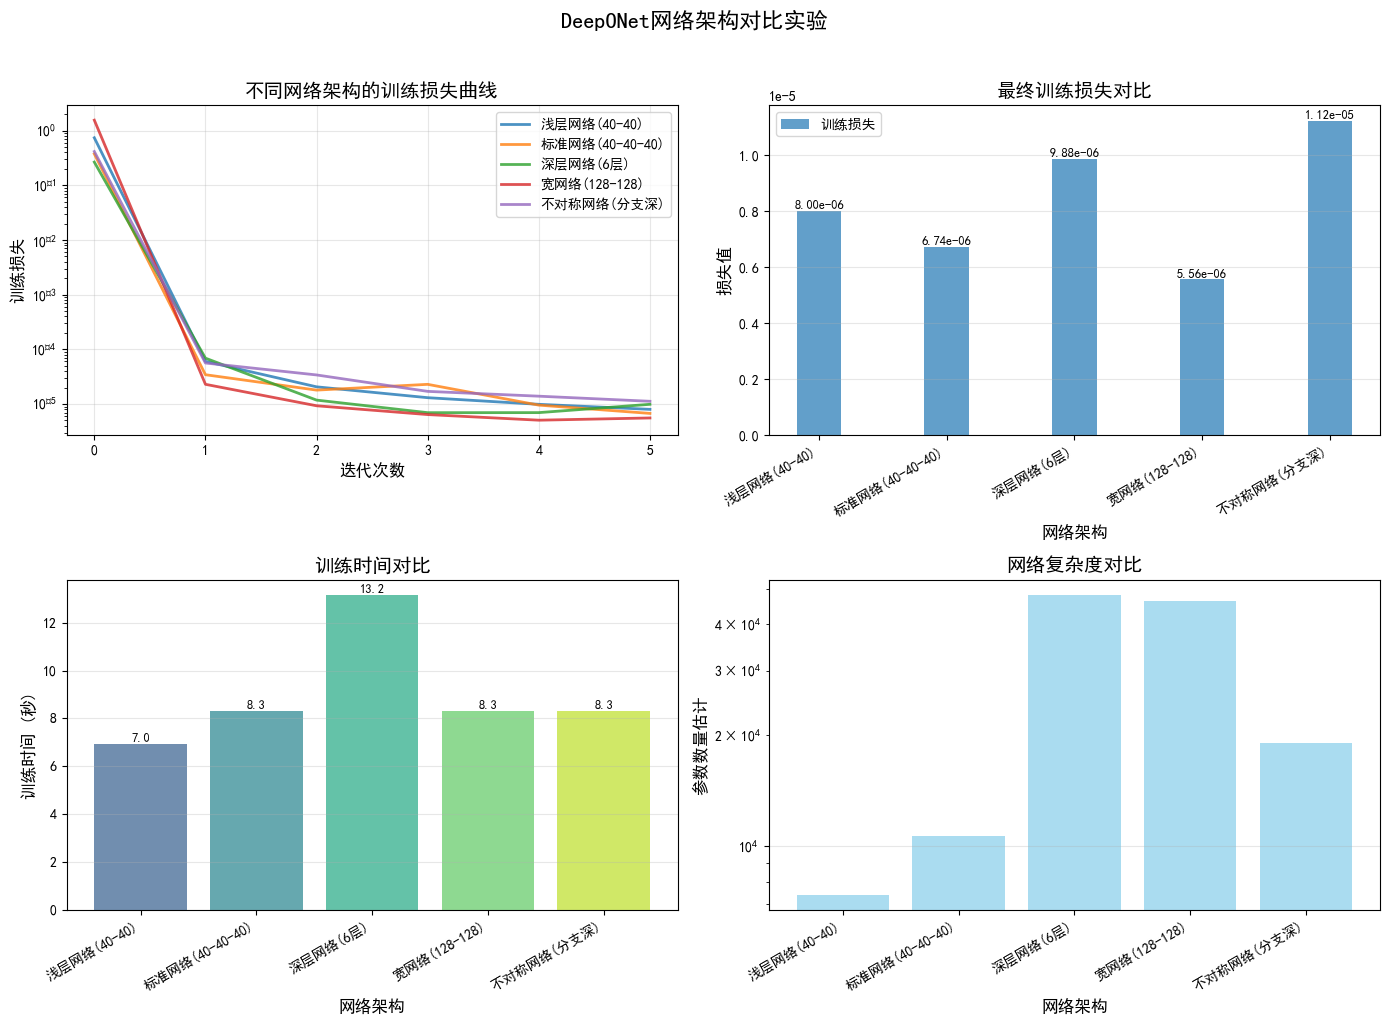


网络架构实验结果汇总
网络架构                 训练损失         训练时间(秒)         参数估计         排名
----------------------------------------------------------------------
宽网络(128-128)         5.56e-06     8.3             46,208       1
标准网络(40-40-40)       6.74e-06     8.3             10,680       2
浅层网络(40-40)          8.00e-06     7.0             7,400        3
深层网络(6层)             9.88e-06     13.2            48,192       4
不对称网络(分支深)           1.12e-05     8.3             19,104       5

----------------------------------------------------------------------
关键发现:
1. 最佳架构: 宽网络(128-128) (损失: 5.56e-06)
2. 最差架构: 不对称网络(分支深) (损失: 1.12e-05)
3. 性能提升: 50.4%
4. 最快训练: 浅层网络(40-40) (7.0秒)

综合效率评分（综合考虑损失和时间）:
  宽网络(128-128)        : 0.891 ★★★★☆
  标准网络(40-40-40)      : 0.787 ★★★☆☆
  浅层网络(40-40)         : 0.785 ★★★☆☆
  不对称网络(分支深)          : 0.390 ★☆☆☆☆
  深层网络(6层)            : 0.119 ☆☆☆☆☆


{'浅层网络(40-40)': {'config': {'branch': [100, 40, 40],
   'trunk': [1, 40, 40],
   'description': '浅层网络，分支和主干各2个隐藏层'},
  'train_loss': np.float32(7.996668e-06),
  'test_loss': np.float32(1.6526268e-05),
  'metric': np.float32(0.01648419),
  'training_time': 6.951100826263428,
  'losshistory': <deepxde.model.LossHistory at 0x20a44041590>,
  'train_state': <deepxde.model.TrainState at 0x20a45ae2d50>},
 '标准网络(40-40-40)': {'config': {'branch': [100, 40, 40, 40],
   'trunk': [1, 40, 40, 40],
   'description': '标准网络，分支和主干各3个隐藏层'},
  'train_loss': np.float32(6.740063e-06),
  'test_loss': np.float32(6.69328e-05),
  'metric': np.float32(0.033785574),
  'training_time': 8.306963682174683,
  'losshistory': <deepxde.model.LossHistory at 0x20a472c1590>,
  'train_state': <deepxde.model.TrainState at 0x20a45b03150>},
 '深层网络(6层)': {'config': {'branch': [100, 64, 64, 64, 64, 64, 64],
   'trunk': [1, 64, 64, 64, 64, 64, 64],
   'description': '深层网络，分支和主干各6个隐藏层'},
  'train_loss': np.float32(9.883184e-06),


In [2]:
experiment_network_architectures()

## 定义域内不同采样策略对比实验

In [ ]:
"""DeepONet定义域内不同采样策略对比实验"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import time

def generate_sampling_strategies(num_points=100):
    """
    在定义域[0,1]内实现4种不同的采样策略
    所有策略都返回相同数量的点，但分布不同
    """
    strategies = {
        "均匀采样": generate_uniform(num_points),
        "边界密集采样": generate_boundary_dense(num_points),
        "中间密集采样": generate_center_dense(num_points),
        "随机采样": generate_random(num_points)
    }
    return strategies

def generate_uniform(n):
    """均匀采样"""
    return np.linspace(0, 1, n)

def generate_boundary_dense(n):
    """边界区域密集采样"""
    # 创建非均匀分布的权重
    weights = np.zeros(n)
    
    # 边界区域权重更高
    for i in range(n):
        x = i / (n-1)  # 0到1
        if x < 0.1 or x > 0.9:
            weights[i] = 3.0  # 边界权重高
        else:
            weights[i] = 1.0  # 内部权重低
    
    # 归一化权重
    weights = weights / np.sum(weights)
    
    # 使用累积权重生成非均匀分布的点
    cum_weights = np.cumsum(weights)
    cum_weights = cum_weights / cum_weights[-1]
    
    # 生成均匀分布的随机数
    u = np.linspace(0, 1, n)
    
    # 通过插值得到非均匀分布的点
    x_nonuniform = np.interp(u, cum_weights, np.linspace(0, 1, n))
    return x_nonuniform

def generate_center_dense(n):
    """中间区域密集采样"""
    # 创建权重，中间区域权重高
    weights = np.zeros(n)
    
    for i in range(n):
        x = i / (n-1)  # 0到1
        if 0.4 < x < 0.6:
            weights[i] = 3.0  # 中间权重高
        else:
            weights[i] = 1.0  # 边界权重低
    
    weights = weights / np.sum(weights)
    cum_weights = np.cumsum(weights)
    cum_weights = cum_weights / cum_weights[-1]
    
    u = np.linspace(0, 1, n)
    x_nonuniform = np.interp(u, cum_weights, np.linspace(0, 1, n))
    return x_nonuniform

def generate_random(n):
    """随机采样（但保持点数相同）"""
    # 生成随机点，然后排序
    x_random = np.random.rand(n)
    x_random.sort()
    return x_random

# 主实验函数
def experiment_sampling_in_domain():
    """测试定义域内不同采样策略对DeepONet性能的影响"""
    print("DeepONet定义域内采样策略对比实验")
    print("="*60)
    
    # 固定参数
    num_functions = 100
    num_points = 100  # 所有策略使用相同的点数
    branch_net = [num_points, 40, 40]  # branch网络第一层必须是采样点数
    trunk_net = [1, 40, 40]
    iterations = 1000
    
    # 生成不同的采样策略
    sampling_strategies = generate_sampling_strategies(num_points)
    
    results = {}
    
    for strategy_name, x_locations in sampling_strategies.items():
        print(f"\n采样策略: {strategy_name}")
        print("-"*40)
        print(f"采样点数: {len(x_locations)}")
        print(f"采样点范围: [{x_locations[0]:.3f}, {x_locations[-1]:.3f}]")
        
        # 生成训练数据
        X_train, y_train = generate_training_data(x_locations, num_functions, num_points)
        
        # 生成测试数据（使用均匀采样）
        x_test = np.linspace(0, 1, num_points)
        X_test, y_test = generate_training_data(x_test, num_functions//2, num_points)
        
        # 创建数据对象
        data = dde.data.TripleCartesianProd(
            X_train=X_train, 
            y_train=y_train,
            X_test=X_test,
            y_test=y_test
        )
        
        # 创建和训练模型
        net = dde.nn.DeepONetCartesianProd(branch_net, trunk_net, "relu", "Glorot normal")
        model = dde.Model(data, net)
        model.compile("adam", lr=0.001)
        
        start_time = time.time()
        losshistory, _ = model.train(iterations=iterations, display_every=500)
        train_time = time.time() - start_time
        
        # 评估模型
        train_loss = losshistory.loss_train[-1][0]
        y_pred = model.predict(X_test)
        test_error = np.mean(np.abs(y_pred - y_test))
        
        # 计算边界误差和内部误差
        boundary_mask = (x_locations < 0.1) | (x_locations > 0.9)
        interior_mask = ~boundary_mask
        
        if np.any(boundary_mask):
            boundary_error = np.mean(np.abs(y_pred[:, boundary_mask] - y_test[:, boundary_mask]))
        else:
            boundary_error = 0
            
        if np.any(interior_mask):
            interior_error = np.mean(np.abs(y_pred[:, interior_mask] - y_test[:, interior_mask]))
        else:
            interior_error = 0
        
        # 保存结果
        results[strategy_name] = {
            'x_locations': x_locations,
            'train_loss': train_loss,
            'test_error': test_error,
            'boundary_error': boundary_error,
            'interior_error': interior_error,
            'train_time': train_time,
            'num_points': len(x_locations)
        }
        
        print(f"训练损失: {train_loss:.4e}")
        print(f"测试误差: {test_error:.4f}")
        print(f"边界误差: {boundary_error:.4f}")
        print(f"内部误差: {interior_error:.4f}")
        print(f"训练时间: {train_time:.1f}秒")
    
    # 可视化结果
    visualize_results(results)
    
    return results

def generate_training_data(x_locations, num_functions, num_points):
    """生成训练数据，确保维度匹配"""
    np.random.seed(42)
    
    # 生成随机函数
    def random_function(x):
        features = np.random.randn(10) * 0.5
        freqs = np.linspace(1, 5, 10)
        result = np.zeros_like(x)
        for i in range(10):
            result += features[i] * np.sin(freqs[i] * x)
        return result
    
    # 生成branch输入（函数值）
    X_branch = []
    y_output = []
    
    for _ in range(num_functions):
        func_vals = random_function(x_locations)
        X_branch.append(func_vals)
        
        # 计算反导数
        integral = np.zeros_like(x_locations)
        for j in range(1, len(x_locations)):
            dx = x_locations[j] - x_locations[j-1]
            integral[j] = integral[j-1] + (func_vals[j-1] + func_vals[j]) * dx / 2
        y_output.append(integral)
    
    X_branch = np.array(X_branch, dtype=np.float32)
    X_trunk = x_locations.reshape(-1, 1).astype(np.float32)
    y_output = np.array(y_output, dtype=np.float32)
    
    # 验证维度
    print(f"数据维度检查:")
    print(f"  X_branch: {X_branch.shape} (应为 [{num_functions}, {num_points}])")
    print(f"  X_trunk: {X_trunk.shape} (应为 [{num_points}, 1])")
    print(f"  y_output: {y_output.shape} (应为 [{num_functions}, {num_points}])")
    
    return (X_branch, X_trunk), y_output

def visualize_results(results):
    """可视化不同采样策略的结果"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    strategies = list(results.keys())
    
    # 1. 采样点分布
    ax = axes[0, 0]
    for i, strategy in enumerate(strategies):
        x_locations = results[strategy]['x_locations']
        ax.scatter(x_locations, np.full_like(x_locations, i), 
                  label=strategy, alpha=0.7, s=30)
    ax.set_xlabel('定义域位置')
    ax.set_ylabel('采样策略')
    ax.set_title('采样点分布对比')
    ax.set_yticks(range(len(strategies)))
    ax.set_yticklabels(strategies)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    # 2. 测试误差对比
    ax = axes[0, 1]
    errors = [results[s]['test_error'] for s in strategies]
    colors = ['blue', 'orange', 'green', 'red']
    bars = ax.bar(strategies, errors, alpha=0.7, color=colors)
    ax.set_xlabel('采样策略')
    ax.set_ylabel('测试误差')
    ax.set_title('测试误差对比')
    ax.tick_params(axis='x', rotation=30)
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, error in zip(bars, errors):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{error:.4f}', ha='center', va='bottom')
    
    # 3. 边界误差 vs 内部误差
    ax = axes[1, 0]
    x = np.arange(len(strategies))
    width = 0.35
    
    boundary_errors = [results[s]['boundary_error'] for s in strategies]
    interior_errors = [results[s]['interior_error'] for s in strategies]
    
    ax.bar(x - width/2, boundary_errors, width, label='边界误差', alpha=0.7, color='red')
    ax.bar(x + width/2, interior_errors, width, label='内部误差', alpha=0.7, color='blue')
    
    ax.set_xlabel('采样策略')
    ax.set_ylabel('预测误差')
    ax.set_title('边界与内部误差对比')
    ax.set_xticks(x)
    ax.set_xticklabels(strategies, rotation=30)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 4. 训练时间对比
    ax = axes[1, 1]
    train_times = [results[s]['train_time'] for s in strategies]
    bars = ax.bar(strategies, train_times, alpha=0.7, color='green')
    ax.set_xlabel('采样策略')
    ax.set_ylabel('训练时间 (秒)')
    ax.set_title('训练时间对比')
    ax.tick_params(axis='x', rotation=30)
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, time_val in zip(bars, train_times):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{time_val:.1f}', ha='center', va='bottom')
    
    plt.suptitle('DeepONet定义域内采样策略对比', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig('sampling_strategies_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印总结
    print("\n" + "="*60)
    print("实验总结")
    print("="*60)
    print(f"{'策略':<15} {'点数':<8} {'测试误差':<12} {'边界误差':<12} {'时间(秒)':<10}")
    print("-"*60)
    
    for strategy in strategies:
        r = results[strategy]
        print(f"{strategy:<15} {r['num_points']:<8} {r['test_error']:<12.4f} "
              f"{r['boundary_error']:<12.4f} {r['train_time']:<10.1f}")



DeepONet定义域内采样策略对比实验

采样策略: 均匀采样
----------------------------------------
采样点数: 100
采样点范围: [0.000, 1.000]
数据维度检查:
  X_branch: (100, 100) (应为 [100, 100])
  X_trunk: (100, 1) (应为 [100, 1])
  y_output: (100, 100) (应为 [100, 100])
数据维度检查:
  X_branch: (50, 100) (应为 [50, 100])
  X_trunk: (100, 1) (应为 [100, 1])
  y_output: (50, 100) (应为 [50, 100])
Compiling model...
'compile' took 0.002184 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.35e+00]    [1.39e+00]    []  
500       [9.63e-05]    [9.84e-05]    []  
1000      [4.48e-05]    [4.58e-05]    []  

Best model at step 1000:
  train loss: 4.48e-05
  test loss: 4.58e-05
  test metric: []

'train' took 1.742060 s

训练损失: 4.4820e-05
测试误差: 0.0048
边界误差: 0.0051
内部误差: 0.0047
训练时间: 1.7秒

采样策略: 边界密集采样
----------------------------------------
采样点数: 100
采样点范围: [0.000, 1.000]
数据维度检查:
  X_branch: (100, 100) (应为 [100, 100])
  X_trunk: (100, 1) (应为 [100, 1])
  y_output: (100, 100) (应为 [100, 100])
数据维度检查:
  X_branch: (50, 

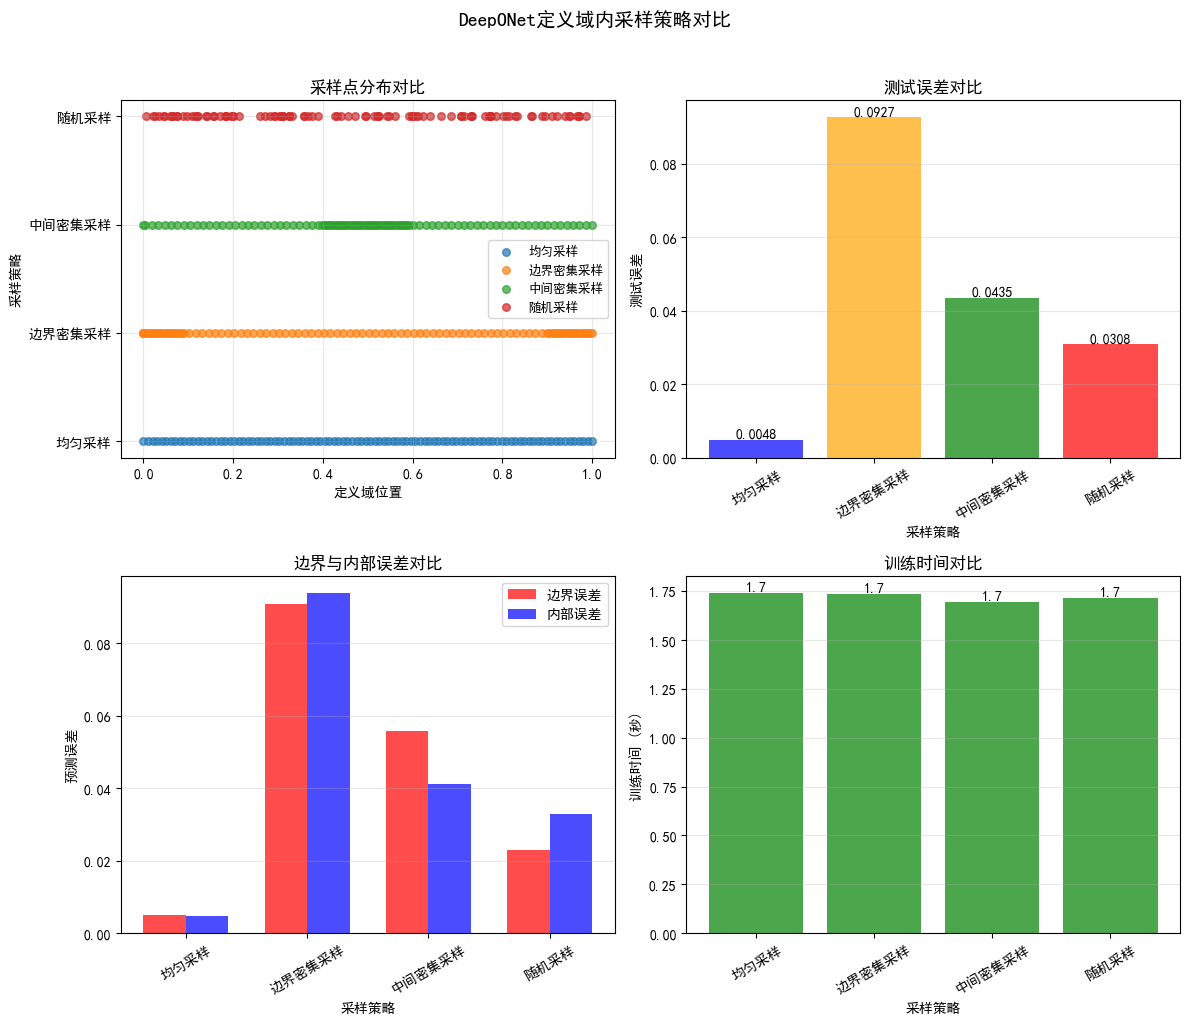


实验总结
策略              点数       测试误差         边界误差         时间(秒)     
------------------------------------------------------------
均匀采样            100      0.0048       0.0051       1.7       
边界密集采样          100      0.0927       0.0909       1.7       
中间密集采样          100      0.0435       0.0558       1.7       
随机采样            100      0.0308       0.0230       1.7       


{'均匀采样': {'x_locations': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
         0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
         0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
         0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
         0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
         0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
         0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
         0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
         0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
         0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
         0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
         0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
         0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
         0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
         0.

In [15]:

np.random.seed(42)
experiment_sampling_in_domain()

## 不同采样点数

In [29]:
"""DeepONet不同采样点数对比实验"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import time

def generate_training_data(num_functions, num_points):
    """生成训练数据"""
    np.random.seed(42)
    
    # 生成随机函数
    def random_function(x):
        features = np.random.randn(10) * 0.5
        freqs = np.linspace(1, 5, 10)
        result = np.zeros_like(x)
        for i in range(10):
            result += features[i] * np.sin(freqs[i] * x)
        return result
    
    # 均匀采样点
    x_locations = np.linspace(0, 1, num_points)
    
    # 生成branch输入（函数值）
    X_branch = []
    y_output = []
    
    for _ in range(num_functions):
        func_vals = random_function(x_locations)
        X_branch.append(func_vals)
        
        # 计算反导数（数值积分）
        integral = np.zeros_like(x_locations)
        for j in range(1, len(x_locations)):
            dx = x_locations[j] - x_locations[j-1]
            integral[j] = integral[j-1] + (func_vals[j-1] + func_vals[j]) * dx / 2
        y_output.append(integral)
    
    X_branch = np.array(X_branch, dtype=np.float32)
    X_trunk = x_locations.reshape(-1, 1).astype(np.float32)
    y_output = np.array(y_output, dtype=np.float32)
    
    return (X_branch, X_trunk), y_output, x_locations

def experiment_different_sample_points():
    """测试不同采样点数对DeepONet性能的影响"""
    print("DeepONet不同采样点数对比实验")
    print("="*60)
    
    # 定义不同的采样点数
    sample_points_list = [20, 50, 100, 200, 500]  # 从小到大
    
    # 固定参数
    num_functions = 100
    test_functions = 20
    iterations = 800
    
    results = {}
    
    for num_points in sample_points_list:
        print(f"\n采样点数: {num_points}")
        print("-"*40)
        
        # 调整网络架构（branch网络第一层必须是采样点数）
        branch_net = [num_points, 40, 40]
        trunk_net = [1, 40, 40]
        
        # 生成训练数据
        X_train, y_train, x_locations = generate_training_data(num_functions, num_points)
        
        # 生成测试数据（使用相同的采样点数）
        X_test, y_test, _ = generate_training_data(test_functions, num_points)
        
        print(f"数据维度检查:")
        print(f"  训练数据: X_branch={X_train[0].shape}, X_trunk={X_train[1].shape}, y={y_train.shape}")
        print(f"  测试数据: X_branch={X_test[0].shape}, X_trunk={X_test[1].shape}, y={y_test.shape}")
        
        # 创建数据对象
        data = dde.data.TripleCartesianProd(
            X_train=X_train, 
            y_train=y_train,
            X_test=X_test,
            y_test=y_test
        )
        
        # 创建和训练模型
        net = dde.nn.DeepONetCartesianProd(branch_net, trunk_net, "relu", "Glorot normal")
        model = dde.Model(data, net)
        model.compile("adam", lr=0.001)
        
        start_time = time.time()
        losshistory, _ = model.train(iterations=iterations, display_every=400)
        train_time = time.time() - start_time
        
        # 评估模型
        train_loss = losshistory.loss_train[-1][0] if losshistory.loss_train else 0
        
        # 使用测试数据预测
        y_pred = model.predict(X_test)
        test_error = np.mean(np.abs(y_pred - y_test))
        
        # 计算边界误差和内部误差
        boundary_mask = (x_locations < 0.1) | (x_locations > 0.9)
        interior_mask = ~boundary_mask
        
        if np.any(boundary_mask):
            boundary_error = np.mean(np.abs(y_pred[:, boundary_mask] - y_test[:, boundary_mask]))
        else:
            boundary_error = 0
            
        if np.any(interior_mask):
            interior_error = np.mean(np.abs(y_pred[:, interior_mask] - y_test[:, interior_mask]))
        else:
            interior_error = 0
        
        # 保存结果
        results[num_points] = {
            'x_locations': x_locations,
            'train_loss': train_loss,
            'test_error': test_error,
            'boundary_error': boundary_error,
            'interior_error': interior_error,
            'train_time': train_time,
            'num_points': num_points,
            'model': model
        }
        
        print(f"训练损失: {train_loss:.4e}")
        print(f"测试误差: {test_error:.4f}")
        print(f"边界误差: {boundary_error:.4f}")
        print(f"内部误差: {interior_error:.4f}")
        print(f"训练时间: {train_time:.1f}秒")
    
    # 可视化结果
    visualize_results(results)
    
    return results

def visualize_results(results):
    """可视化不同采样点数的结果"""
    fig = plt.figure(figsize=(15, 10))
    
    sample_points_list = list(results.keys())
    
    # 1. 采样点分布对比
    ax1 = plt.subplot(2, 3, 1)
    for i, num_points in enumerate(sample_points_list):
        x_locations = results[num_points]['x_locations']
        # 为了清晰显示，对点数多的进行稀疏显示
        if num_points > 100:
            indices = np.linspace(0, len(x_locations)-1, 50).astype(int)
            display_points = x_locations[indices]
        else:
            display_points = x_locations
            
        ax1.scatter(display_points, np.full_like(display_points, i), 
                   label=f'{num_points}点', alpha=0.7, s=20)
    
    ax1.set_xlabel('定义域位置')
    ax1.set_ylabel('采样点数')
    ax1.set_title('采样点分布对比')
    ax1.set_yticks(range(len(sample_points_list)))
    ax1.set_yticklabels([f'{n}点' for n in sample_points_list])
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=8)
    
    # 2. 测试误差 vs 采样点数
    ax2 = plt.subplot(2, 3, 2)
    test_errors = [results[n]['test_error'] for n in sample_points_list]
    
    ax2.plot(sample_points_list, test_errors, 'bo-', linewidth=2, markersize=8)
    ax2.set_xlabel('采样点数')
    ax2.set_ylabel('测试误差')
    ax2.set_title('采样点数 vs 测试误差')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    
    # 添加误差标签
    for x, y in zip(sample_points_list, test_errors):
        ax2.text(x, y, f'{y:.4f}', ha='center', va='bottom')
    
    # 3. 训练时间 vs 采样点数
    ax3 = plt.subplot(2, 3, 3)
    train_times = [results[n]['train_time'] for n in sample_points_list]
    
    ax3.plot(sample_points_list, train_times, 'gs-', linewidth=2, markersize=8)
    ax3.set_xlabel('采样点数')
    ax3.set_ylabel('训练时间 (秒)')
    ax3.set_title('训练时间 vs 采样点数')
    ax3.set_xscale('log')
    ax3.grid(True, alpha=0.3)
    
    for x, y in zip(sample_points_list, train_times):
        ax3.text(x, y, f'{y:.1f}', ha='center', va='bottom')
    
    # 4. 边界误差 vs 内部误差对比
    ax4 = plt.subplot(2, 3, 4)
    x_pos = np.arange(len(sample_points_list))
    width = 0.35
    
    boundary_errors = [results[n]['boundary_error'] for n in sample_points_list]
    interior_errors = [results[n]['interior_error'] for n in sample_points_list]
    
    ax4.bar(x_pos - width/2, boundary_errors, width, label='边界误差', alpha=0.7, color='red')
    ax4.bar(x_pos + width/2, interior_errors, width, label='内部误差', alpha=0.7, color='blue')
    
    ax4.set_xlabel('采样点数')
    ax4.set_ylabel('预测误差')
    ax4.set_title('边界与内部误差对比')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'{n}' for n in sample_points_list])
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. 收敛效率分析
    ax5 = plt.subplot(2, 3, 5)
    
    # 计算每增加100个点的误差下降
    if len(sample_points_list) >= 2:
        efficiency = []
        labels = []
        
        for i in range(1, len(sample_points_list)):
            prev_points = sample_points_list[i-1]
            curr_points = sample_points_list[i]
            prev_error = test_errors[i-1]
            curr_error = test_errors[i]
            
            points_increase = curr_points - prev_points
            error_decrease = prev_error - curr_error
            
            if points_increase > 0:
                # 每增加100个点的误差下降
                eff = error_decrease / (points_increase / 100) if error_decrease > 0 else 0
                efficiency.append(eff)
                labels.append(f'{prev_points}-{curr_points}')
        
        if efficiency:
            bars = ax5.bar(labels, efficiency, alpha=0.7, color='orange')
            ax5.set_xlabel('点数区间')
            ax5.set_ylabel('每百点误差下降')
            ax5.set_title('数据利用效率')
            ax5.tick_params(axis='x', rotation=30)
            ax5.grid(True, alpha=0.3, axis='y')
            
            for bar, eff in zip(bars, efficiency):
                ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                        f'{eff:.4f}', ha='center', va='bottom')
    
    # 6. 综合评分和推荐
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # 计算综合评分
    scores = []
    for num_points in sample_points_list:
        result = results[num_points]
        
        # 归一化各项指标（越小越好）
        errors = [results[n]['test_error'] for n in sample_points_list]
        times = [results[n]['train_time'] for n in sample_points_list]
        
        norm_error = (result['test_error'] - min(errors)) / (max(errors) - min(errors) + 1e-10)
        norm_time = (result['train_time'] - min(times)) / (max(times) - min(times) + 1e-10)
        norm_points = (result['num_points'] - min(sample_points_list)) / (max(sample_points_list) - min(sample_points_list) + 1e-10)
        
        # 综合评分：误差权重50%，时间权重30%，点数权重20%（点数少得分高）
        score = 0.5 * (1 - norm_error) + 0.3 * (1 - norm_time) + 0.2 * (1 - norm_points)
        scores.append(score)
    
    # 生成总结文本
    summary_text = "实验总结:\n\n"
    
    # 找到最佳和最差
    best_idx = np.argmin(test_errors)
    worst_idx = np.argmax(test_errors)
    
    summary_text += f"最佳点数: {sample_points_list[best_idx]}点\n"
    summary_text += f"  测试误差: {test_errors[best_idx]:.4f}\n"
    summary_text += f"  训练时间: {results[sample_points_list[best_idx]]['train_time']:.1f}秒\n\n"
    
    summary_text += f"最差点数: {sample_points_list[worst_idx]}点\n"
    summary_text += f"  测试误差: {test_errors[worst_idx]:.4f}\n"
    summary_text += f"  训练时间: {results[sample_points_list[worst_idx]]['train_time']:.1f}秒\n\n"
    
    summary_text += "建议:\n"
    summary_text += "• 20-50点: 快速原型，计算快\n"
    summary_text += "• 100点: 平衡选择\n"
    summary_text += "• 200-500点: 精度高，但计算慢\n"
    
    # 计算性能提升
    min_points = min(sample_points_list)
    max_points = max(sample_points_list)
    
    if min_points in results and max_points in results:
        min_error = results[min_points]['test_error']
        max_error = results[max_points]['test_error']
        
        error_reduction = min_error - max_error
        reduction_percent = (error_reduction / min_error) * 100 if min_error > 0 else 0
        
        time_increase = results[max_points]['train_time'] - results[min_points]['train_time']
        
        summary_text += f"\n从{min_points}点到{max_points}点:\n"
        summary_text += f"  误差减少: {error_reduction:.4f} ({reduction_percent:.1f}%)\n"
        summary_text += f"  时间增加: {time_increase:.1f}秒"
    
    ax6.text(0.1, 0.5, summary_text, fontsize=11, 
             verticalalignment='center', horizontalalignment='left',
             transform=ax6.transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('DeepONet不同采样点数对比实验结果', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('different_sample_points_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印详细结果
    print("\n" + "="*70)
    print("不同采样点数实验结果汇总")
    print("="*70)
    print(f"{'采样点数':<10} {'测试误差':<12} {'边界误差':<12} {'内部误差':<12} {'训练时间':<12} {'排名'}")
    print("-"*70)
    
    # 按测试误差排序
    sorted_items = sorted(results.items(), key=lambda x: x[1]['test_error'])
    for rank, (num_points, result) in enumerate(sorted_items, 1):
        print(f"{num_points:<10} {result['test_error']:<12.4f} "
              f"{result['boundary_error']:<12.4f} {result['interior_error']:<12.4f} "
              f"{result['train_time']:<12.1f} {rank}")

DeepONet不同采样点数对比实验

采样点数: 20
----------------------------------------
数据维度检查:
  训练数据: X_branch=(100, 20), X_trunk=(20, 1), y=(100, 20)
  测试数据: X_branch=(20, 20), X_trunk=(20, 1), y=(20, 20)
Compiling model...
'compile' took 0.002594 s

Training model...

Step      Train loss    Test loss     Test metric
0         [5.47e-01]    [6.43e-01]    []  
400       [1.26e-04]    [1.08e-04]    []  
800       [4.72e-05]    [4.05e-05]    []  

Best model at step 800:
  train loss: 4.72e-05
  test loss: 4.05e-05
  test metric: []

'train' took 1.524674 s

训练损失: 4.7182e-05
测试误差: 0.0048
边界误差: 0.0054
内部误差: 0.0046
训练时间: 1.5秒

采样点数: 50
----------------------------------------
数据维度检查:
  训练数据: X_branch=(100, 50), X_trunk=(50, 1), y=(100, 50)
  测试数据: X_branch=(20, 50), X_trunk=(50, 1), y=(20, 50)
Compiling model...
'compile' took 0.002348 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.16e+00]    [8.68e-01]    []  
400       [4.55e-04]    [4.96e-04]    []  
800       [6.

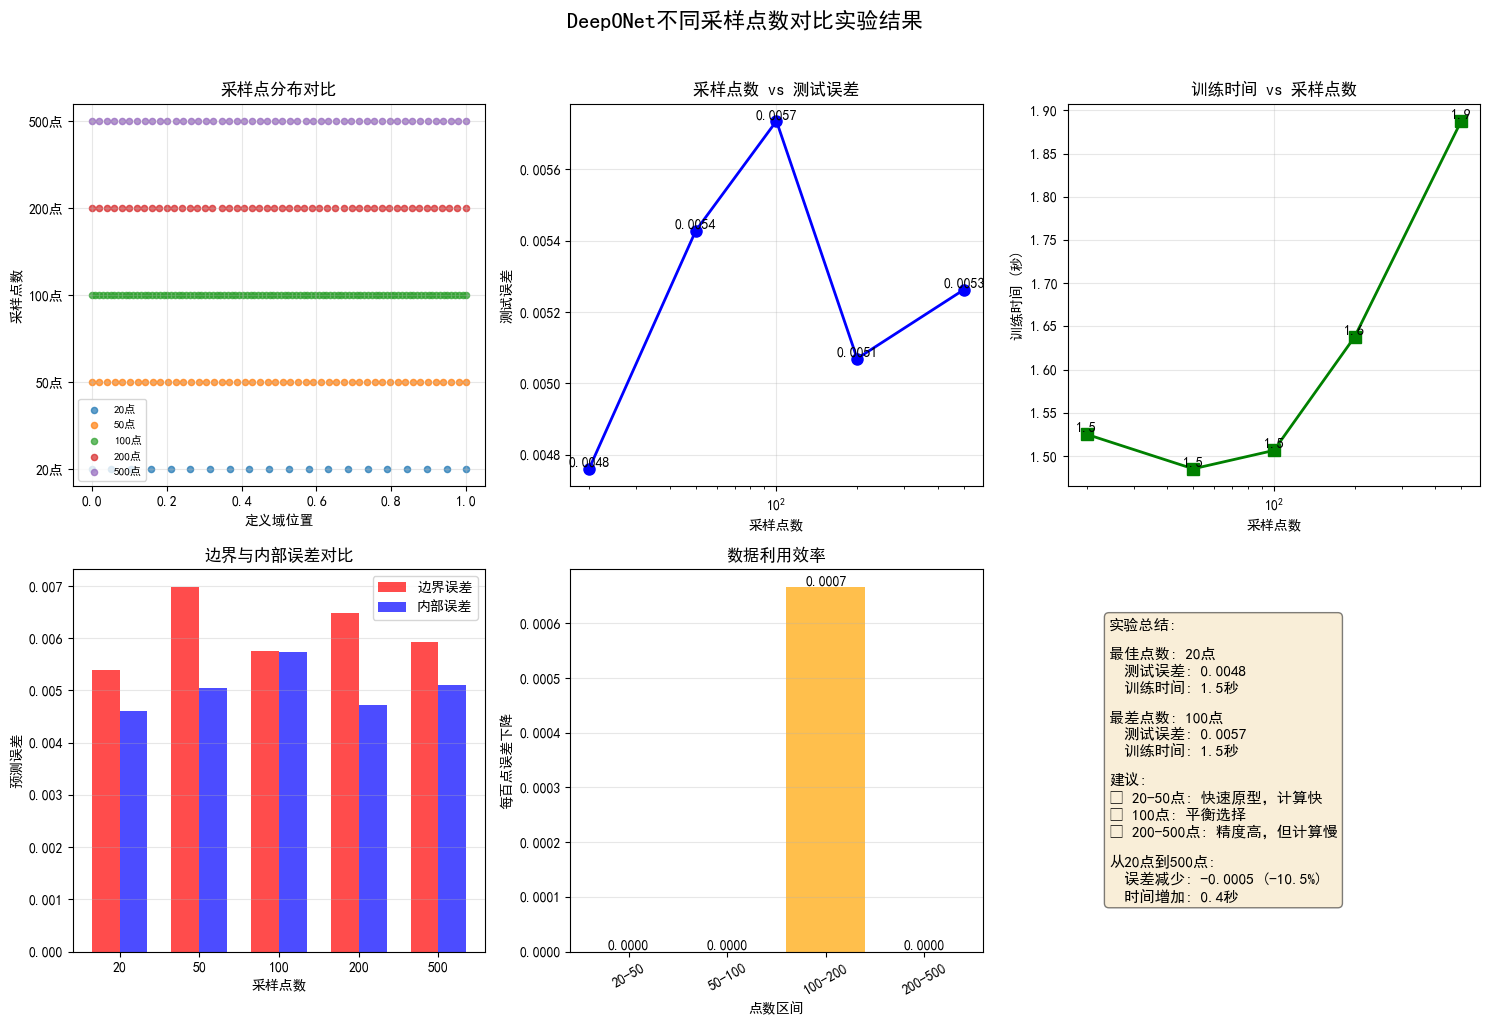


不同采样点数实验结果汇总
采样点数       测试误差         边界误差         内部误差         训练时间         排名
----------------------------------------------------------------------
20         0.0048       0.0054       0.0046       1.5          1
200        0.0051       0.0065       0.0047       1.6          2
500        0.0053       0.0059       0.0051       1.9          3
50         0.0054       0.0070       0.0050       1.5          4
100        0.0057       0.0057       0.0057       1.5          5


In [30]:
np.random.seed(42)
results = experiment_different_sample_points()